In [44]:
import os
import glob
import pandas as pd
import numpy as np
import tables
import matplotlib.pylab as plt
import seaborn as sns
from tierpsy.analysis.feat_create.obtainFeaturesHelper import WormStats
from tierpsy.analysis.feat_create.obtainFeatures import FUNC_FOR_DIV

def read_feat_events(feat_file):
    fid= tables.File(feat_file, 'r')
    
    features_events = {}
    node = fid.get_node('/features_events')
    for worn_n in node._v_children.keys():
        worm_node = fid.get_node('/features_events/' + worn_n)
        
        for feat in worm_node._v_children.keys():
            if not feat in features_events:
                features_events[feat] = {}
            dat = fid.get_node(worm_node._v_pathname, feat)[:]
            features_events[feat][worn_n] = dat
    
    def dict2array(dd):
        return np.concatenate([val for val in dd.values()])
    
    features_events = {feat:dict2array(val) for feat, val in features_events.items()}
    return features_events

#masks_dir = '/Volumes/SAMSUNG_USB/David_Miller/DM_unc-4_Adult_L4_060417/'
#results_dir = '/Volumes/SAMSUNG_USB/David_Miller/DM_unc-4_Adult_L4_060417/Results'

masks_dir = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/DM_unc-4_Adult_L4_060417'
results_dir = masks_dir.replace('MaskedVideos', 'Results')

fnames = glob.glob(os.path.join(masks_dir, '*.hdf5'))
time_sets = {}
for fname in fnames:
    base_name = os.path.basename(fname).replace('.hdf5', '')
    time_str = base_name.rpartition('_')[-1]
    time_rounded = round(int(time_str)/100)
    time_sets[base_name] = time_rounded

In [2]:
feat_files = glob.glob(os.path.join(results_dir, '*_features.hdf5'))
features_data = {}
wstat = WormStats()

plate_stats={}
for stat_type in FUNC_FOR_DIV:
    plate_stats[stat_type] = np.full(len(feat_files), np.nan, wstat.feat_avg_dtype)


for ii, feat_file in enumerate(feat_files):
    base_name = os.path.basename(feat_file).replace('_features.hdf5', '')
    print(base_name)
    with pd.HDFStore(feat_file, 'r') as fid:
        feat_timeseries = fid['/features_timeseries']
        feat_timeseries['motion_modes_f'] = np.nan
        
        for ind in feat_timeseries['worm_index'].unique():
            feats_worm = feat_timeseries[feat_timeseries['worm_index']==ind]
            motion_modes = feats_worm['motion_modes'].fillna(method='ffill')
            feat_timeseries['motion_modes_f'] = motion_modes
        
        dd = {x:feat_timeseries[x] for x in feat_timeseries}
        worm_features_dict = {**dd, **read_feat_events(feat_file)}
        
        #%% eliminate sign from bends since it is not known
        worm_features_dict = {x: np.abs(val) if 'bend' in x else val for x,val in worm_features_dict.items()}
        features_data[base_name] = worm_features_dict
        
        for stat_type, stat_func in FUNC_FOR_DIV.items():
            plate_stats[stat_type][ii] = wstat.getWormStats(worm_features_dict, stat_func)

base_names = [os.path.basename(x).replace('_features.hdf5', '') for x in feat_files]
strains = [x.partition('_')[0] for x in base_names]
time_set = [time_sets[x] for x in  base_names]
for stat_type in FUNC_FOR_DIV:        
    plate_stats[stat_type] = pd.DataFrame(plate_stats[stat_type])
    plate_stats[stat_type]['base_name'] = base_names
    plate_stats[stat_type]['strain'] = strains
    plate_stats[stat_type]['time_set'] = time_set
    

unc-4 (c2323)_worms9_food1-3_Set1_Pos4_Ch1_06042017_152216
unc-4 (c2323)_worms10_food1-3_Set1_Pos4_Ch2_06042017_152216
unc-4 (c2323)_worms10_food1-3_Set1_Pos4_Ch3_06042017_152206
unc-4 (c2323)_worms10_food1-3_Set2_Pos5_Ch1_06042017_154809
unc-4 (c2323)_worms10_food1-3_Set2_Pos5_Ch2_06042017_154809
unc-4 (c2323)_worms10_food1-3_Set2_Pos5_Ch3_06042017_154758
unc-4 (c2323)_worms10_nofood_Set3_Pos4_Ch1_06042017_160550
unc-4 (c2323)_worms10_nofood_Set3_Pos4_Ch2_06042017_160550
unc-4 (c2323)_worms10_nofood_Set3_Pos4_Ch3_06042017_160555
unc-4 (c2323)_worms10_nofood_Set4_Pos5_Ch1_06042017_162251
unc-4 (c2323)_worms10_nofood_Set4_Pos5_Ch2_06042017_162251
unc-4 (c2323)_worms10_nofood_Set4_Pos5_Ch3_06042017_162257
unc-4 (c2323);ceh-12_worms10_food1-3_Set1_Pos4_Ch4_06042017_152206
unc-4 (c2323);ceh-12_worms10_food1-3_Set1_Pos4_Ch6_06042017_152155
unc-4 (c2323);ceh-12_worms10_food1-3_Set2_Pos5_Ch4_06042017_154758
unc-4 (c2323);ceh-12_worms10_food1-3_Set2_Pos5_Ch5_06042017_154751
unc-4 (c2323);ceh-1

In [3]:
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

def getPValues(control_data, curr_data):
    p_values = pd.Series(index=curr_data.columns)
    for feat in curr_data.columns:
        x = control_data[feat].values.astype(np.float)
        y = curr_data[feat].values.astype(np.float)
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]
        #if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        #    continue
        _, p_value = ttest_ind(x,y, equal_var=False)
        #_, p_value = ranksums(x,y)
        
        #p_value positive if N2 is larger than the strain
        p_values[feat] = p_value

    p_values = p_values.dropna()
    p_values = p_values.sort_values()
    
    #correct for false discovery rate using 2-stage Benjamini-Krieger-Yekutieli
    reject, pvals_corrected, alphacSidak, alphacBonf = \
    smm.multipletests(p_values.values, method = 'fdr_tsbky')
    
    p_values_corr = pd.Series(pvals_corrected, index=p_values.index)
    return p_values, p_values_corr





In [36]:
stat_type = 'medians'

index_cols = ['worm_index', 'n_frames', 'n_valid_skel', 
              'first_frame', 'base_name', 'strain', 'time_set']
feat_cols = [x for x in plate_stats[stat_type].columns if x not in index_cols]
feat_cols = [x for x in feat_cols if not any(x.endswith(bad_ext) for bad_ext in ['_pos', '_neg', '_abs'])]
feat_cols = [x for x in feat_cols if not any(x.endswith(bad_ext) for bad_ext in ['_paused', '_backward', '_foward', '_forward'])]


feat_bends = [x for x in feat_cols if 'bend' in x and x != 'bend_count']
feat_motions = [x for x in feat_cols if any(good_ext in x for good_ext in ['backward', 'forward'])]

print(feat_cols)
print('MOTIONS:', feat_motions)
print('BENDS:', feat_bends)

feat_cols = feat_motions + feat_bends

['worm_dwelling', 'head_dwelling', 'midbody_dwelling', 'tail_dwelling', 'length', 'head_width', 'midbody_width', 'tail_width', 'area', 'area_length_ratio', 'width_length_ratio', 'head_bend_mean', 'neck_bend_mean', 'midbody_bend_mean', 'hips_bend_mean', 'tail_bend_mean', 'head_bend_sd', 'neck_bend_sd', 'midbody_bend_sd', 'hips_bend_sd', 'tail_bend_sd', 'max_amplitude', 'amplitude_ratio', 'primary_wavelength', 'secondary_wavelength', 'track_length', 'eccentricity', 'bend_count', 'tail_to_head_orientation', 'head_orientation', 'tail_orientation', 'eigen_projection_1', 'eigen_projection_2', 'eigen_projection_3', 'eigen_projection_4', 'eigen_projection_5', 'eigen_projection_6', 'head_tip_speed', 'head_speed', 'midbody_speed', 'tail_speed', 'tail_tip_speed', 'head_tip_motion_direction', 'head_motion_direction', 'midbody_motion_direction', 'tail_motion_direction', 'tail_tip_motion_direction', 'foraging_amplitude', 'foraging_speed', 'head_crawling_amplitude', 'midbody_crawling_amplitude', 'tai

In [37]:
%matplotlib inline
import matplotlib.pylab as plt

def compare_feats(plate_data, p_values):
    base_names = plate_data['strain'].unique()
    lab_order = sorted(base_names)

    for icol, (col, p_val) in enumerate(p_values.iteritems()):
        #print(col, p_val)
        if icol % 5==0:
            plt.figure(figsize=(20,4))
        plt.subplot(1, 5, (icol%5)+1)
        ax =sns.boxplot(x="strain", 
                          y=col,
                          data=plate_data, 
                          order=lab_order)
        ax =sns.stripplot(x="strain", 
                          y=col,
                          data=plate_data, 
                          order=lab_order,
                         jitter=True,
                         color="r",
                         alpha=.5)
        plt.title(p_val)
        #ax.legend_.remove()
        for item in ax.get_xticklabels():
            item.set_rotation(90)

def get_feats_pvalues(plate_data, valid_cols):
    ctr_ind = plate_data['strain']=='unc-4 (c2323)'
    curr_ind = plate_data['strain']=='unc-4 (c2323);ceh-12'

    control_data = plate_data.loc[ctr_ind, valid_cols]
    curr_data = plate_data.loc[curr_ind, valid_cols]
    p_values, p_values_corr = getPValues(control_data, curr_data)
    
    return p_values, p_values_corr

ADULT FOOD
midbody_bend_sd                   0.001719
neck_bend_sd                      0.007911
hips_bend_sd                      0.012969
backward_motion_time_ratio        0.016130
backward_motion_frequency         0.061498
backward_distance                 0.069101
backward_motion_distance_ratio    0.073849
tail_bend_mean                    0.076855
tail_bend_sd                      0.079378
backward_time                     0.108054
midbody_bend_mean                 0.113512
inter_backward_time               0.114468
forward_motion_time_ratio         0.132397
forward_motion_distance_ratio     0.156482
hips_bend_mean                    0.233373
forward_distance                  0.404509
forward_time                      0.412491
forward_motion_frequency          0.464596
neck_bend_mean                    0.621664
head_bend_sd                      0.702831
inter_backward_distance           0.720255
inter_forward_distance            0.747510
inter_forward_time                0.865076


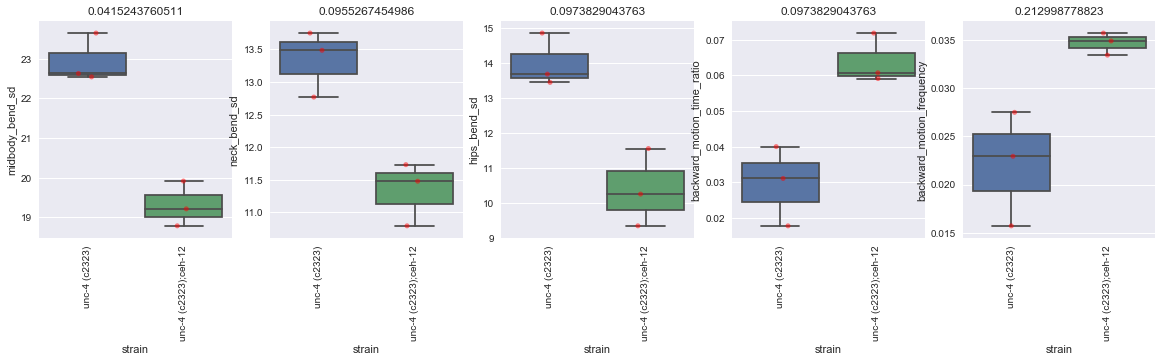

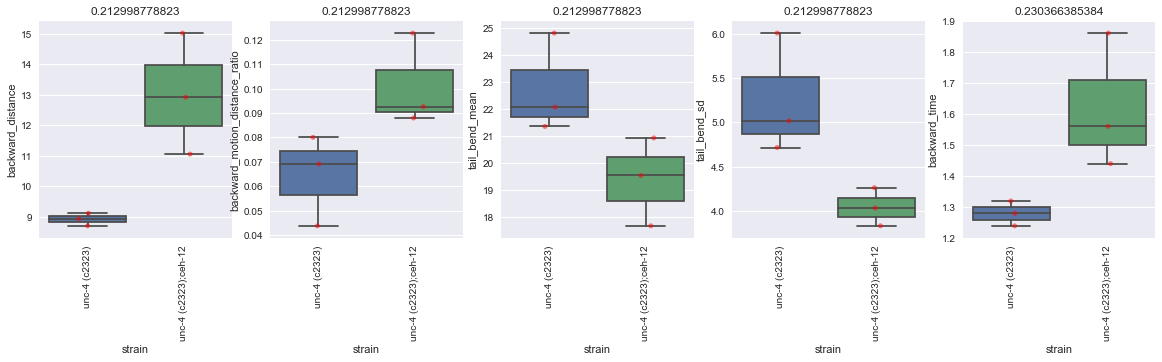

In [43]:
plate_stats_f = plate_stats[stat_type][plate_stats[stat_type]['time_set']==1522]
p_values, p_values_corr = get_feats_pvalues(plate_stats_f, feat_cols)
print('ADULT FOOD')
print(p_values.sort_values())

compare_feats(plate_stats_f, p_values_corr[:10])

ADULT NO FOOD
backward_motion_time_ratio        0.036279
midbody_bend_sd                   0.036279
tail_bend_mean                    0.036279
neck_bend_mean                    0.043920
backward_time                     0.065447
hips_bend_mean                    0.174298
hips_bend_sd                      0.247897
head_bend_mean                    0.247897
midbody_bend_mean                 0.247897
inter_backward_time               0.247897
backward_distance                 0.249918
forward_motion_distance_ratio     0.249918
forward_motion_time_ratio         0.254358
head_bend_sd                      0.254358
backward_motion_frequency         0.327560
inter_forward_time                0.327560
forward_distance                  0.327560
inter_backward_distance           0.327560
tail_bend_sd                      0.327560
backward_motion_distance_ratio    0.345127
forward_time                      0.345127
neck_bend_sd                      0.435917
inter_forward_distance            0.7507

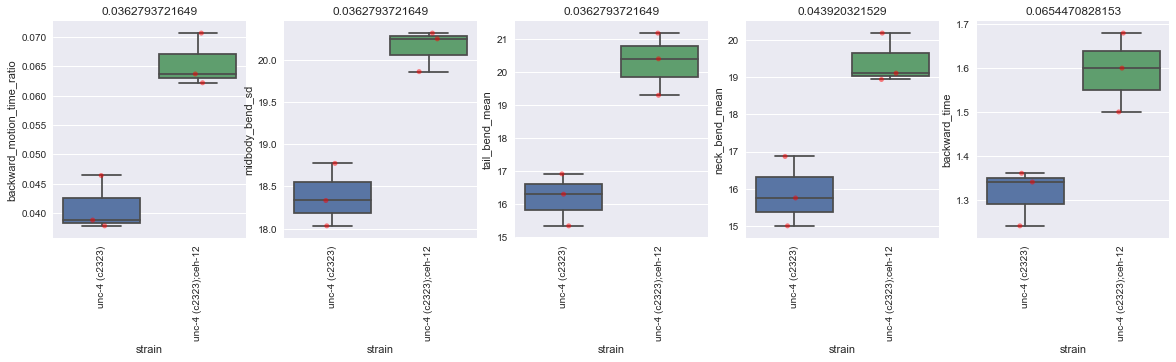

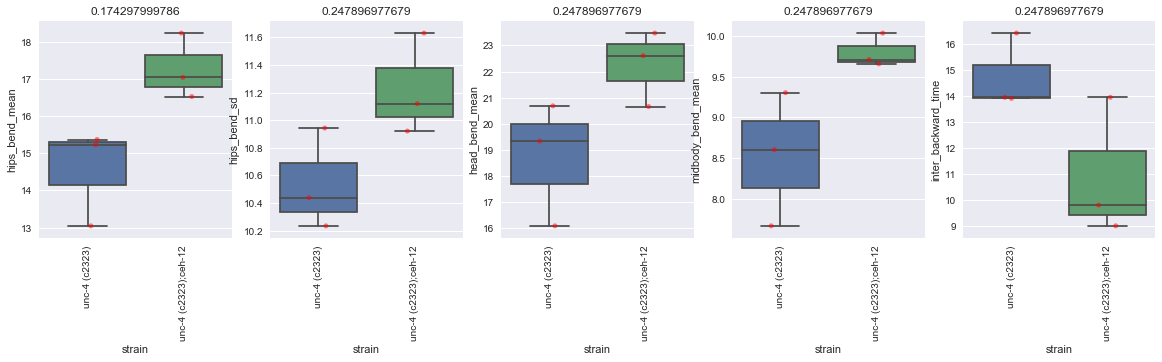

In [39]:
plate_stats_f = plate_stats[stat_type][plate_stats[stat_type]['time_set']==1548]
p_values, p_values_corr = get_feats_pvalues(plate_stats_f, feat_cols)

print('ADULT NO FOOD')
print(p_values_corr.sort_values())
compare_feats(plate_stats_f, p_values_corr[:10])



L4 FOOD
head_bend_mean                    0.131800
midbody_bend_sd                   0.131800
head_bend_sd                      0.131800
neck_bend_sd                      0.131800
backward_motion_distance_ratio    0.131800
backward_motion_time_ratio        0.286646
backward_distance                 0.286646
midbody_bend_mean                 0.340496
tail_bend_sd                      0.340496
backward_time                     0.340496
hips_bend_sd                      0.340496
tail_bend_mean                    0.778184
backward_motion_frequency         0.778184
inter_backward_time               0.896478
neck_bend_mean                    0.896478
inter_backward_distance           0.896478
hips_bend_mean                    0.896478
dtype: float64


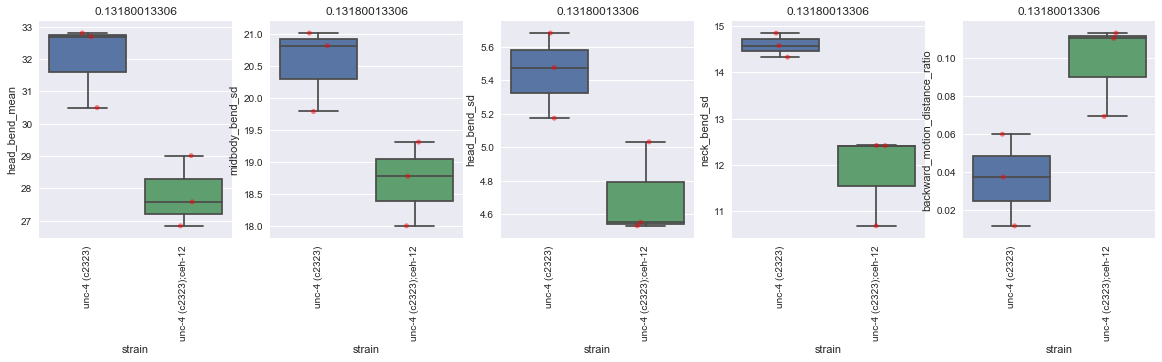

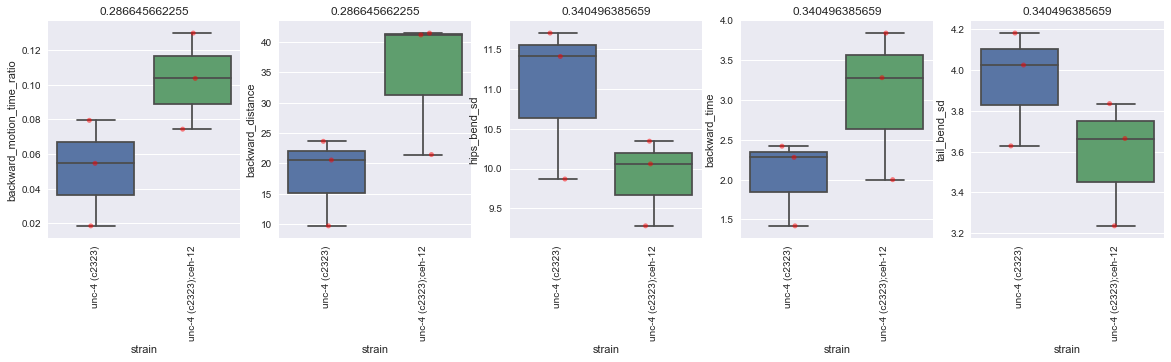

In [31]:
plate_stats_f = plate_stats[stat_type][plate_stats[stat_type]['time_set']==1606]
p_values, p_values_corr = get_feats_pvalues(plate_stats_f, feat_cols)
print('L4 FOOD')
print(p_values_corr.sort_values())
compare_feats(plate_stats_f, p_values_corr[:10])

L4 FOOD
midbody_bend_sd                   0.367900
backward_motion_distance_ratio    0.367900
tail_bend_mean                    0.367900
backward_distance                 0.367900
inter_forward_time                0.367900
backward_time                     0.367900
forward_motion_time_ratio         0.367900
backward_motion_frequency         0.367900
backward_motion_time_ratio        0.367900
forward_motion_distance_ratio     0.401825
neck_bend_mean                    0.567446
hips_bend_sd                      0.614222
hips_bend_mean                    0.696738
tail_bend_sd                      0.735084
forward_distance                  0.840120
inter_backward_time               0.840120
inter_backward_distance           0.840120
head_bend_sd                      0.840120
head_bend_mean                    0.840120
neck_bend_sd                      0.914467
midbody_bend_mean                 0.914467
forward_motion_frequency          0.914467
forward_time                      0.951531
int

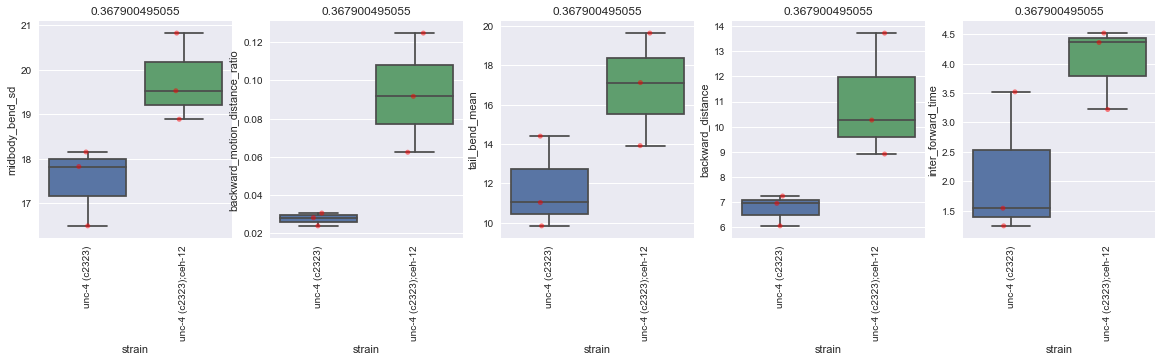

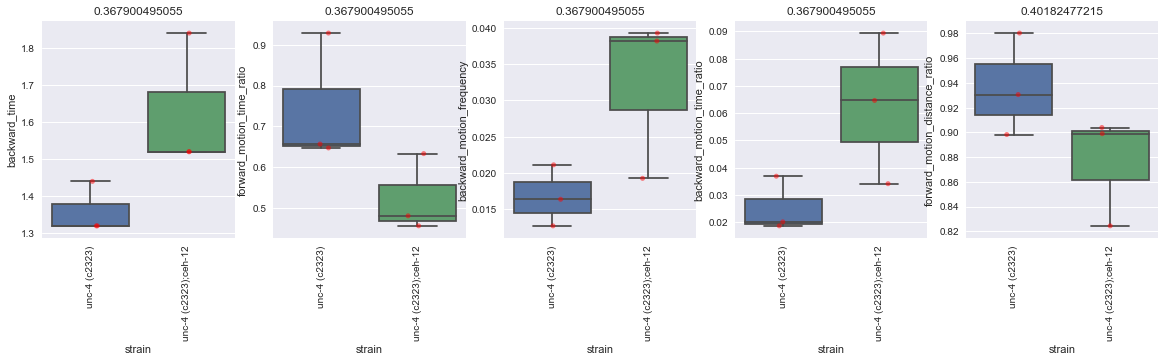

In [40]:
plate_stats_f = plate_stats[stat_type][plate_stats[stat_type]['time_set']==1623]
p_values, p_values_corr = get_feats_pvalues(plate_stats_f, feat_cols)
print('L4 FOOD')
print(p_values_corr.sort_values())
compare_feats(plate_stats_f, p_values_corr[:10])

In [ ]:
plate_stats[stat_type]['time_set'].unique()